# Visual Inspection of Motorcycle Connecting comps
Author: Matteo Periani<br>
student-id: 0001039848<br>
date: 11/2022


In [385]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

visualize = True

Import first image

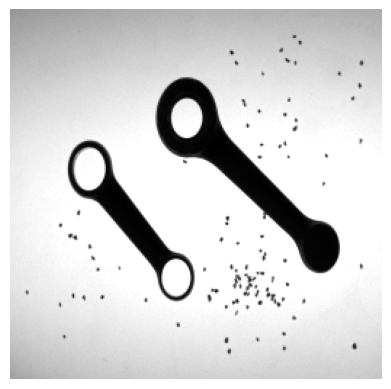

In [386]:
img_path = "./images/task2/task23/TESI90.BMP"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()

### Image Binzarization using Otsu
**Otsu's method** is a alorithm to find the best threshold to binirize an imaghe. It iterate over all the possible values of threshold and measure the spread of background and foreground pixels. In this implementation instead use classic within-group variance, we use the **inter-group** varaince, to speed up the computation (no need to compute the classes variance).

Indeed, it can be proved that
$$ \sigma^2(t) = \sigma^2_W(t) + \sigma^2_B(t) $$
where $\sigma^2_W$ is *within-group* variance and is the *between-group*. So, it ealsy to see that if in the other way the best threshold minize $\sigma^2_W$, $\sigma^2_B$ is maximaized. So, now once computed all the variances, we had to find the threshold value that give us the maximum value. 

In [387]:
# RETURNS: the optimal threshold according to OTSU's algorithm
def otsu(img): 

    # Create the histogram of the image and compute the probabilty of each grayscale level
    h = np.zeros((256,))
    
    for l in range(256):
        h[l] = np.sum(img == l)
        
    p = h/np.sum(h)
    
    # BETWEEN-GROUP VARIANCE list
    bgv = []
    
    # For each possible Threshold we compute the mean and the  of the two groups
    for T in range(256):   
        if np.sum(h[:T+1]) > 0 and np.sum(h[T+1:]) > 0:
            
            mu1, mu2 = 0, 0
            q1 = 0
       
            # compute of the the mean and the probability of belogin to a class
            for l in range(256):
                if l <= T:
                    mu1 += l * p[l] / np.sum(h[:T+1])
                    q1 += p[l]
                else:
                    mu2 += l * p[l] / np.sum(h[T+1:])
            
            # Appending the INTER-GROUP VARIANCE to the list
            bgv.append(q1 * (1 - q1) * (mu1 - mu2) ** 2)
        else:
            bgv.append(-1000)
    
    return np.argmax(bgv)

During binarization, a grayscale image is converted to B/W, reducing the 256 shades of gray to 2. In order to, we need to find a threshold **T** and apply some thresholding criteria (i.e. all pixel above T got 255 and other 0).

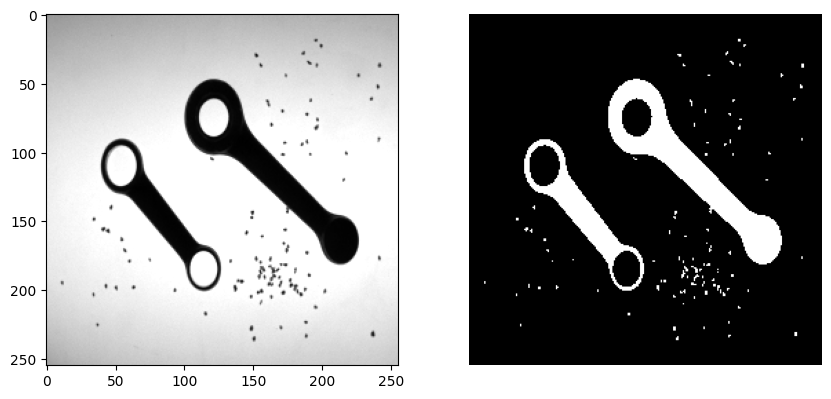

In [388]:
# Selection of the Otsu's threshold
T = otsu(img)

# Image Binarization
binarized_img = 255-((img > T) * 255).astype('uint8')

f, plts = plt.subplots(1, 2, figsize=(10,10)) 
plts[0].imshow(img, cmap="gray")
plts[1].imshow(binarized_img, cmap="gray")
plt.axis('off')
plt.show()

### Remove dust and dirt noise
start with a median blur to remove the most dust and dirt

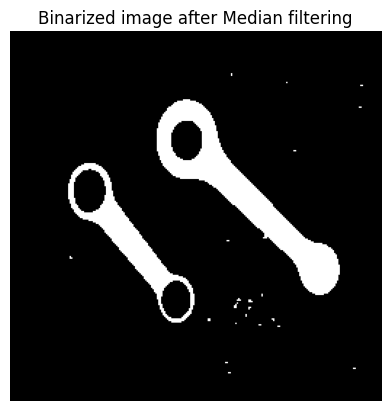

In [389]:
img_bin_blur = cv2.medianBlur(binarized_img, 3)

plt.imshow(img_bin_blur, cmap='gray')
plt.title('Binarized image after Median filtering')
plt.axis('off')
plt.show()

Affine noise elimination (Dilation -> Opening -> 2x Dilation -> 2x Erosion)

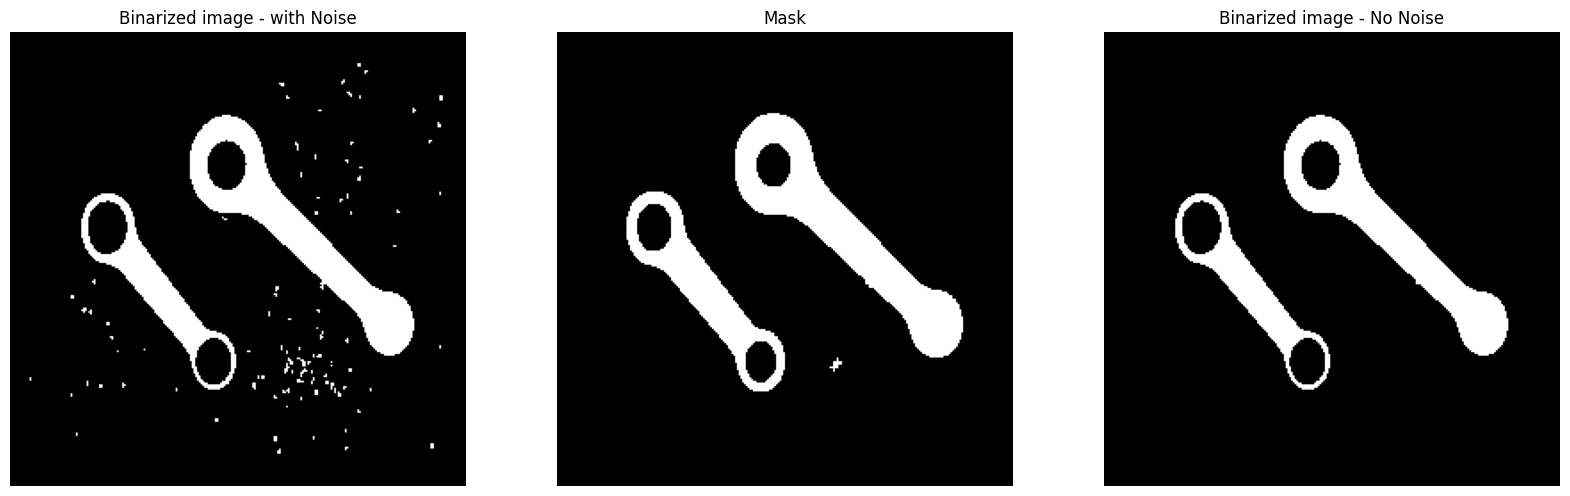

In [390]:
# Kernels for Morphological Operators
square_k = lambda x: cv2.getStructuringElement(cv2.MORPH_RECT,(x,x))
cross_k = lambda x: cv2.getStructuringElement(cv2.MORPH_CROSS,(x,x))

# Dilation (to keep thin borders safe from Opening) -> Opening -> 2x Dilation -> 2x Erosion
dilation1 = cv2.dilate(img_bin_blur, square_k(3), iterations = 1)
opening = cv2.morphologyEx(dilation1, cv2.MORPH_OPEN, cross_k(5))
dilation2 = cv2.dilate(opening, square_k(3), iterations = 2)
erosion = cv2.erode(dilation2, square_k(3), iterations = 2)

# Other 2 steps of median filtering to remove residual noise
mask = cv2.medianBlur(cv2.medianBlur(cv2.bitwise_and(binarized_img, erosion), 3), 3)

# The final binarized image is obtained from the original image and the related mask
img_bin_denoised = cv2.bitwise_and(mask, binarized_img)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(binarized_img, cmap='gray')
plt.title('Binarized image - with Noise')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(erosion, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_bin_denoised, cmap='gray')
plt.title('Binarized image - No Noise')
plt.axis('off')
plt.show()


### Separate touching comps
As first things, remove comps holes to prevent internal ersosion.

(-0.5, 255.5, 254.5, -0.5)

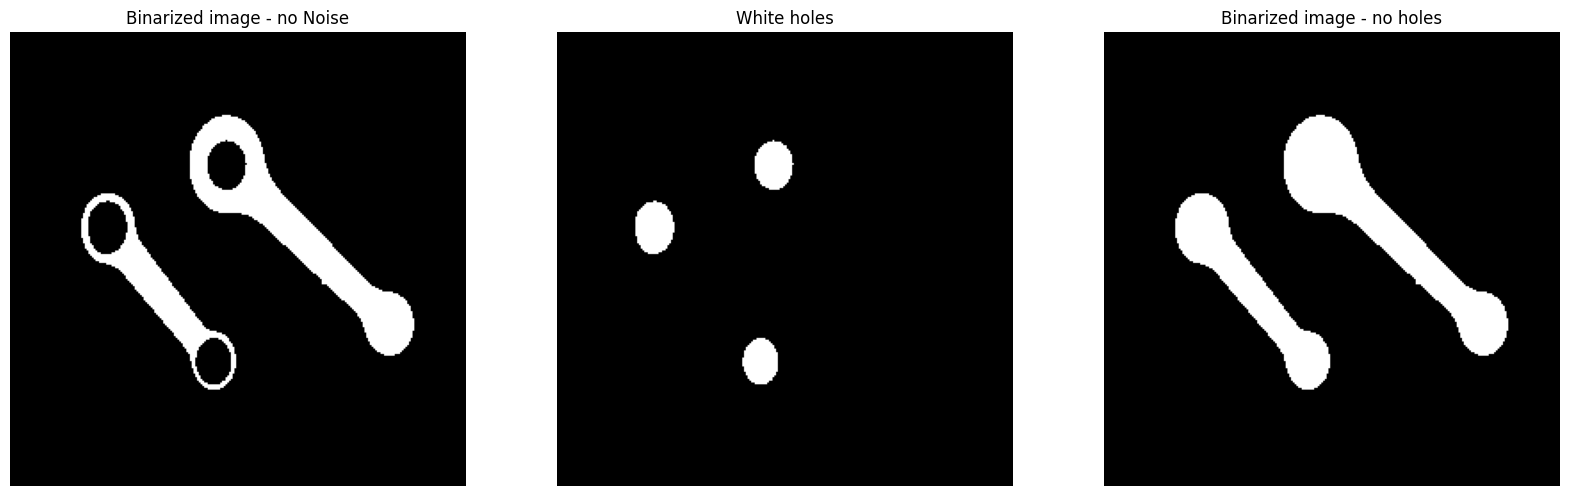

In [391]:
white_holes = img_bin_denoised.copy()
# Flood-filling
h, w = img_bin_denoised.shape[:2]
mask_filling = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(white_holes, mask_filling, (0,0), 255);
white_holes = cv2.bitwise_not(white_holes)
img_no_holes = img_bin_denoised + white_holes

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(img_bin_denoised, cmap='gray')
plt.title('Binarized image - no Noise')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(white_holes, cmap='gray')
plt.title('White holes')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_no_holes, cmap='gray')
plt.title('Binarized image - no holes')
plt.axis('off')

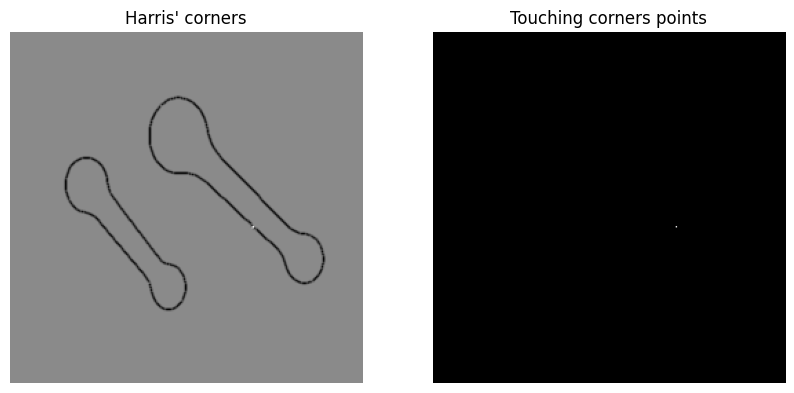

In [392]:
# Find Corners img_no_holes
harris = cv2.cornerHarris(img_no_holes,2,5,0.04)

# Find Centroids of touching corners
_, _, _, centroids = cv2.connectedComponentsWithStats(((harris>1)*255).astype('uint8'), 4, cv2.CV_32S)

# Show corners in the image
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(harris, cmap='gray')
plt.title("Harris' corners")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(((harris>1)*255).astype('uint8'), cmap='gray')
plt.title("Touching corners points")
plt.axis('off')
plt.show()

In order to discard centroids that are very close to each other, we filter them by tresholing based on distance

In [393]:
# start form index 1 to not take into account the all image barycenter
centroids = [tuple(c) for c in centroids[1:]]
good_centroids = centroids

print(f"All centroids: {centroids}")

i = 1    
for c1 in centroids:
    for c2 in centroids[i::1]:
        if(dist.euclidean(c1, c2) < 10):
            good_centroids.remove(c2)
    i+=1
    
print(f"Good centroids: {good_centroids}")

All centroids: [(176.0, 141.0)]
Good centroids: [(176.0, 141.0)]


Now, to separate comps we have to find the pairs of points that are used in the next step to draw the line. To do this, we need to find the closet touple of points cordinates and store them together. Beacuse of that, we need at lest two centorids to perform this operation.

In [394]:
lines_extremes = []
n_centroids = len(good_centroids)

# If there are at least two good centroids
if n_centroids >= 2:
    # Find all the Conjunctions between pairs of near Centroids
    for i in range(n_centroids):
        min_pair_dist = np.Inf
        for j in range(n_centroids):
            if i != j:
                d = dist.euclidean(good_centroids[i], good_centroids[j])
                if d < min_pair_dist and d > 10: 
                    min_pair_dist = d
                    best_i = i
                    best_j = j
        if (good_centroids[best_i], good_centroids[best_j]) not in lines_extremes:
            lines_extremes.append((good_centroids[best_i], good_centroids[best_j]))
    
print(lines_extremes)

[]


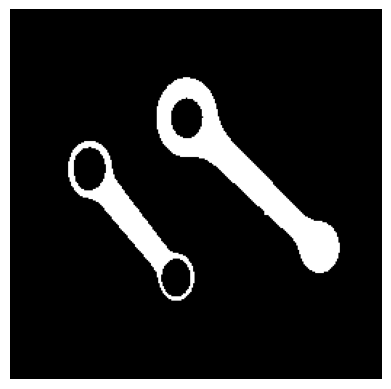

In [395]:
lines_extremes = [(round(pt[0]), round(pt[1])) for e in lines_extremes for pt in e]

im_bin_sep = np.copy(img_bin_denoised)

# Draw separation lines
for i in range(0, len(lines_extremes), 2):
    im_bin_sep = cv2.line(img_no_holes, lines_extremes[i], lines_extremes[i+1], color=[0,0,0], thickness=1)
    
plt.imshow(im_bin_sep, cmap='gray')
plt.axis('off')
plt.show()

In [396]:
# just for readibility purposes
img_bin = im_bin_sep.copy()

### Compute connected components

In [397]:
def solve_class_equality(img, l_p, l_q):
    img[img == l_q] = l_p
    return img

def _2_scan_algorithm(img):
    label = 0
    labeled = np.zeros(img.shape, dtype='uint8')
    
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            if img[i, j] == 255:
                l_p = img[i-1, j]
                l_q = img[i, j-1]
                
                # if the left and top pixel have different lables -> merge class
                if l_p == 255 and l_q == 255 and labeled[i, j-1] != labeled[i-1, j]:
                    labeled[i, j] = labeled[i, j-1] # choose above label
                    labeled = solve_class_equality(labeled, labeled[i, j-1], labeled[i-1, j])
                
                # if left pixel is labeled -> assign this label
                elif l_q == 255:
                    labeled[i, j] = labeled[i, j-1]
                 
                # if above is labeled -> assign this label   
                elif l_p == 255:
                    labeled[i, j] = labeled[i-1, j]
                
                # assign new label
                else:
                    label += 1
                    labeled[i, j] = label

    return labeled
                

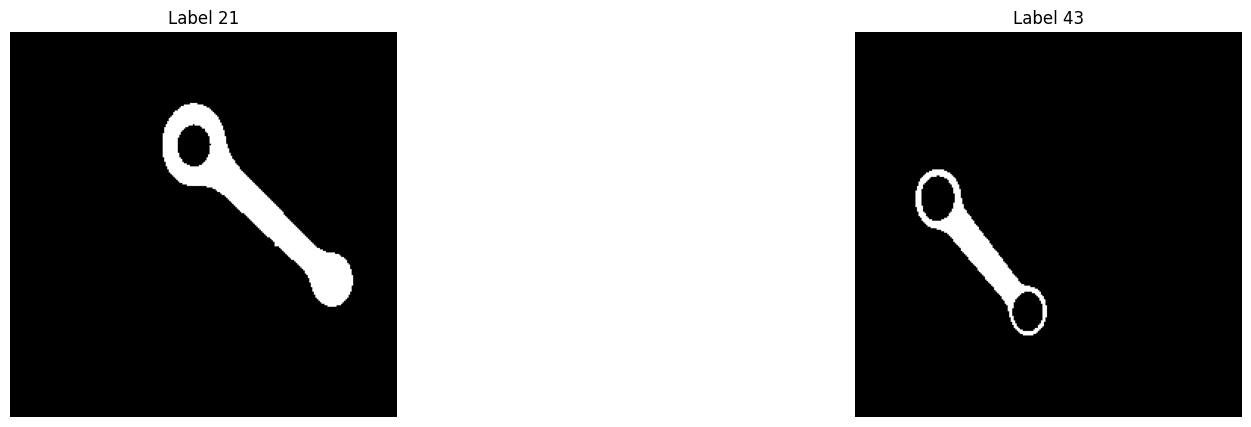

In [398]:
labeled_img = _2_scan_algorithm(img_bin)

# Store the labels (excluding the BG)
labels = np.unique(labeled_img)[1:]

# Show the connected components
plt.figure(figsize=(20,5))
for idx, l in enumerate(labels):
    plt.subplot(1,len(labels), idx+1)
    plt.imshow((labeled_img == l)*255, cmap='gray')
    plt.title(f'Label {l}')
    plt.axis('off')
plt.show()

As you can see, some errors could be present (due noise in the binarization process), so to remove it, I decide to keep only those connected regions that have an area graten tha a chosen treshold.

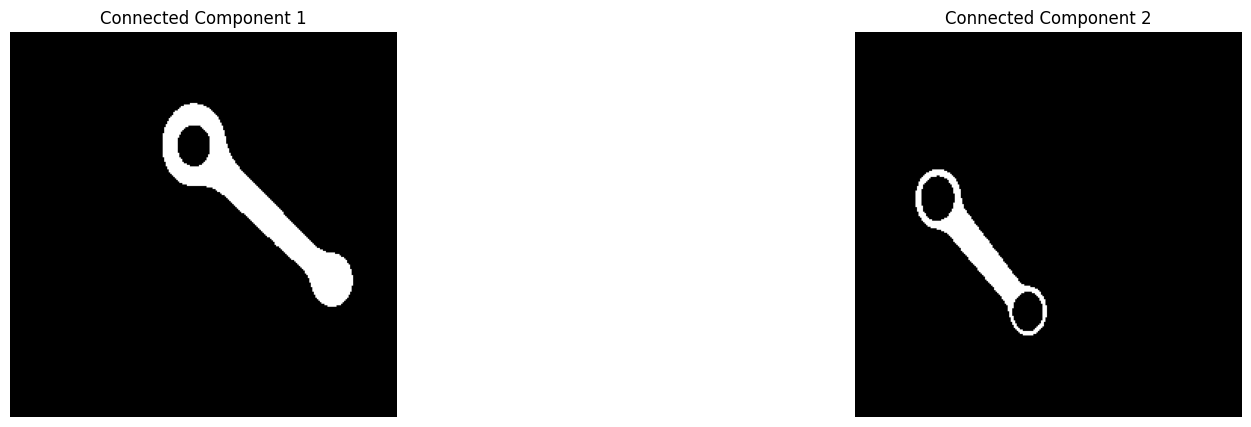

In [399]:
T_area = 50

objects = []

for idx, l in enumerate(labels):
    if np.sum(labeled_img == l) > T_area:
        obj = ((labeled_img == l)*255).astype('uint8')
        obj_dilatated = cv2.dilate(obj, square_k(3), iterations = 2)
        obj = cv2.medianBlur(cv2.bitwise_and(obj_dilatated, img_bin_denoised), 3)
        objects.append(obj)
        

# Show retained objects
plt.figure(figsize=(20,5))
for idx, comp in enumerate(objects):
    plt.subplot(1,len(objects), idx+1)
    plt.imshow(comp, cmap='gray')
    plt.title(f'Connected Component {idx+1}')
    plt.axis('off')  
plt.show()

Remove components with no holes.


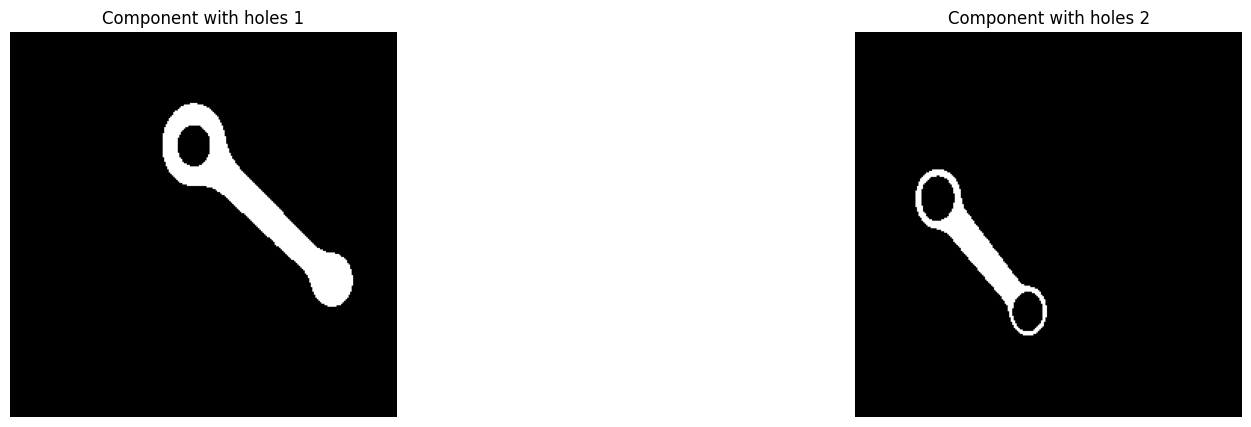

In [400]:
visualize = False
T_radius = 1

obj_with_holes = []

for idx, obj in enumerate(objects):
    # get components of the inverse (comps is background, holes and background is foreground)
    tmp = _2_scan_algorithm(255-obj)
    
    if len(np.unique(tmp)[1:]) > 0:
        obj_with_holes.append(obj)
 
plt.figure(figsize=(20,5))
for idx, obj in enumerate(obj_with_holes):
    plt.subplot(1,len(obj_with_holes), idx+1)
    plt.imshow(obj, cmap='gray')
    plt.title(f'Component with holes {idx+1}')
    plt.axis('off')  
plt.show()

### Compute the pose of the object

The pose of an object is the combination of the object's position and orientation. To get the pose of the object we have to evaluate its barycenter and moments.

In [401]:
def get_barycenter(img):
    
    # Area
    A = np.sum(img==255)
    
    # Vectors for Matrix pcompucts
    v_i = np.arange(0, img.shape[0])
    v_j = np.transpose(np.arange(0, img.shape[1]))
       
    # Matrix pcompucts to get the coordinates
    i = (np.sum(np.dot(v_i, (img==255)))/A).astype('uint8')
    j = (np.sum(np.dot((img==255), v_j))/A).astype('uint8')
    
    return i, j

def get_moments(img):
    
    # Barycenter
    i_b, j_b = get_barycenter(img)
    
    moments = {}
    
    for m, n in [(0, 0), (1, 1), (2, 0), (0, 2)]:
        moment = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i,j] == 255:
                    moment += (i - i_b)**m * (j - j_b)**n
                
        moments[f"m{m}{n}"] = moment  
        
    return moments

# RETURNS: the coordinates to plot the lines with the function cv2.line()
def line(theta, centre, shape):
    i_start, i_end = 0, 0
    j_start, j_end = 0, 0
           
    
    if (theta*180/math.pi < 45) or (135 < theta*180/math.pi < 225) or (315 < theta*180/math.pi):
        i_start, i_end = 0, 0
        j_start, j_end = 0, 0
        for i in range(shape[0]):
            j = np.tan(theta)*(i-centre[0]) + centre[1]
            if 0 < j < shape[1]:
                if j_start == 0 and i_start == 0:
                    j_start = j.astype('uint8')
                    i_start = i

                j_end = j.astype('uint8')
                i_end = i 
    else:
        for j in range(shape[1]):
            i = (1/np.tan(theta))*(j-centre[1]) + centre[0]
            if 0 < i < shape[0]:
                if j_start == 0 and i_start == 0:
                    j_start = j
                    i_start = i.astype('uint8')

                j_end = j
                i_end = i.astype('uint8')
    
    return (j_start, i_start), (j_end, i_end)

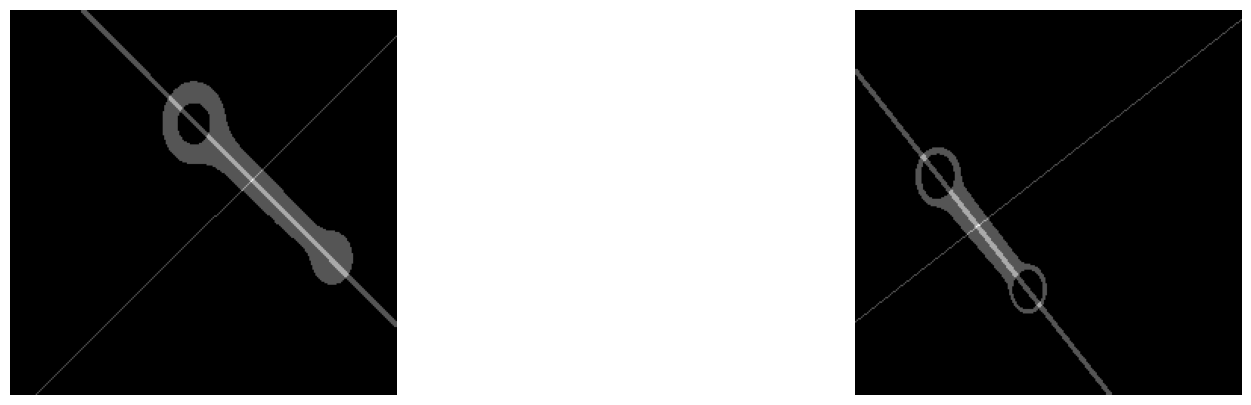

In [402]:
pose = []

plt.figure(figsize=(20,5)) 

for idx, obj in enumerate(obj_with_holes):
    
    # Area & Barycenter of the object
    moments = get_moments(obj)
    A = moments["m00"]
    i_b, j_b = get_barycenter(obj)
    
    # Evaluation of θ
    theta = -0.5 * np.arctan((2 * moments["m11"]) / (moments["m02"] - moments["m20"]))

    # Adjustment of theta (when M_02 > M_20 the axes are inverted...)
    if moments["m02"] > moments["m20"]:
        theta = theta + math.pi/2
     
    # draw barycenter
    cv2.circle(tmp, (j_b, i_b), 2, (255, 255, 255), -1) 

    # draw majow axis
    startP, endP = line(theta, (i_b, j_b), comp.shape)
    major = cv2.line(np.zeros(obj.shape), startP, endP, color=(255,255,255), thickness=2)
    
    # draw minor axis
    startP, endP = line(theta+math.pi/2, (i_b, j_b), comp.shape)
    minor = cv2.line(np.zeros(obj.shape), startP, endP, color=(255,255,255), thickness=1)
    
    pose.append((theta, (i_b, j_b), major, minor))
    
    plt.subplot(1, len(obj_with_holes), idx+1)
    plt.imshow(major+minor+obj, cmap="gray")
    plt.axis('off')

plt.show()

## Compute the MER

In [403]:
def find_mer_and_bar_width(comp, theta, B):
    alpha = -math.sin(theta)
    beta = math.cos(theta)

    # major axis
    a = alpha
    b = -beta
    c = beta * B[0] - alpha * B[1]
    
    # minor axis
    a_p = beta
    b_p = alpha
    c_p = - beta * B[1] - alpha * B[0]
    
    # Points at barycenter width
    min_wb_1, min_wb_2 = 100000, 100000

    dMAmin, dMImin = 100000, 100000
    dMAmax, dMImax = -100000, -100000
    normMA = math.sqrt(a ** 2 + b ** 2)
    normMI = math.sqrt(a_p ** 2 + b_p ** 2)

    contours, _ = cv2.findContours(comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for p in contours[0]:
        j = p[0][0]
        i = p[0][1]

        dMA = (a * j + b * i + c) / normMA
        dMI = (a_p * j + b_p * i + c_p) / normMI

        if dMA < dMAmin:
            c1 = (j, i)
            dMAmin = dMA

        if dMA > dMAmax:
            c2 = (j, i)
            dMAmax = dMA

        if dMI < dMImin:
            c3 = (j, i)
            dMImin = dMI

        if dMI > dMImax:
            c4 = (j, i)
            dMImax = dMI
            
        if abs(dMA) < min_wb_1 and dMI > 0:
            wb_1 = (j, i)
            min_wb_1 = abs(dMA)

        if abs(dMA) < min_wb_2 and dMI < 0:
            wb_2 = (j, i)
            min_wb_2 = abs(dMA)

    # Calculate 'c' coefficients for lines of MER's sides
    cl_1 = -(a * c1[0] + b * c1[1])
    cl_2 = -(a * c2[0] + b * c2[1])
    cw_1 = -(a_p * c3[0] + b_p * c3[1])
    cw_2 = -(a_p * c4[0] + b_p * c4[1])
    
    den = (a * b_p - b * a_p)

    # Calculate MER vertices
    v1 = ((b * cw_1 - b_p * cl_1) / den,
          (a_p * cl_1 - a * cw_1) / den)
    
    v2 = ((b * cw_2 - b_p * cl_1) / den,
          (a_p * cl_1 - a * cw_2) / den)
    
    v3 = ((b * cw_1 - b_p * cl_2) / den,
          (a_p * cl_2 - a * cw_1) / den)
    
    v4 = ((b * cw_2 - b_p * cl_2) / den,
          (a_p * cl_2 - a * cw_2) / den)

    return v1, v2, v3, v4, wb_1, wb_2

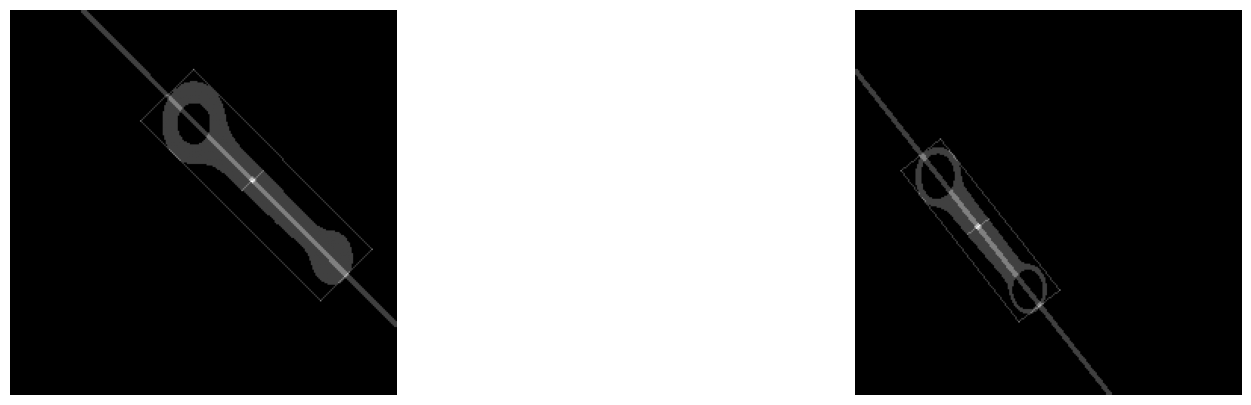

In [404]:
rods = []
rods_info = []

plt.figure(figsize=(20,5))
for idx, obj in enumerate(obj_with_holes):

    theta = pose[idx][0]
    i_b, j_b = pose[idx][1]
    
    # find MER  
    v1, v2, v3, v4, wb_1, wb_2 = find_mer_and_bar_width(obj, theta,(i_b, j_b))
    
    # Calculate length and width as euclidean distance
    length = dist.euclidean(v1, v3)
    width = dist.euclidean(v1, v2)
    
    bar_width = dist.euclidean(wb_1, wb_2)
    
    enlongatedness = length / width
   
    # if the object ins't a comp, it's ignored and removed from image (just for visualization purpose)
    if enlongatedness > 1.8:
        rods.append(obj)
        # add in sequence MER, length, width, and past information
    else:
        continue
    
    # draw barycenter
    bar = cv2.circle(np.zeros(obj.shape), (j_b, i_b), 2, (255, 255, 255), -1)
    
    major, minor = pose[idx][2:]
    
    # draw mer
    l1 = cv2.line(np.zeros(obj.shape), (int(v1[0]), int(v1[1])), (int(v3[0]), int(v3[1])), (255, 255, 255), 1, cv2.LINE_AA)
    l2 = cv2.line(np.zeros(obj.shape), (int(v2[0]), int(v2[1])), (int(v1[0]), int(v1[1])), (255, 255, 255), 1, cv2.LINE_AA)
    l3 = cv2.line(np.zeros(obj.shape), (int(v3[0]), int(v3[1])), (int(v4[0]), int(v4[1])), (255, 255, 255), 1, cv2.LINE_AA)
    l4 = cv2.line(np.zeros(obj.shape), (int(v4[0]), int(v4[1])), (int(v2[0]), int(v2[1])), (255, 255, 255), 1, cv2.LINE_AA)
    
    #draw bar_width
    bar_width_line = cv2.line(np.zeros(obj.shape), (wb_1[0], wb_1[1]), (wb_2[0], wb_2[1]), (255, 255, 255), 1, cv2.LINE_AA)       
    
    rods_info.append(((l1, l2, l3, l4), length, width, bar_width, pose[idx]))
    
    plt.subplot(1, len(obj_with_holes), idx+1)
    plt.imshow(l1+l2+l3+l4+major+bar_width_line+bar+obj, cmap='gray')
    plt.axis('off')
    
plt.show()

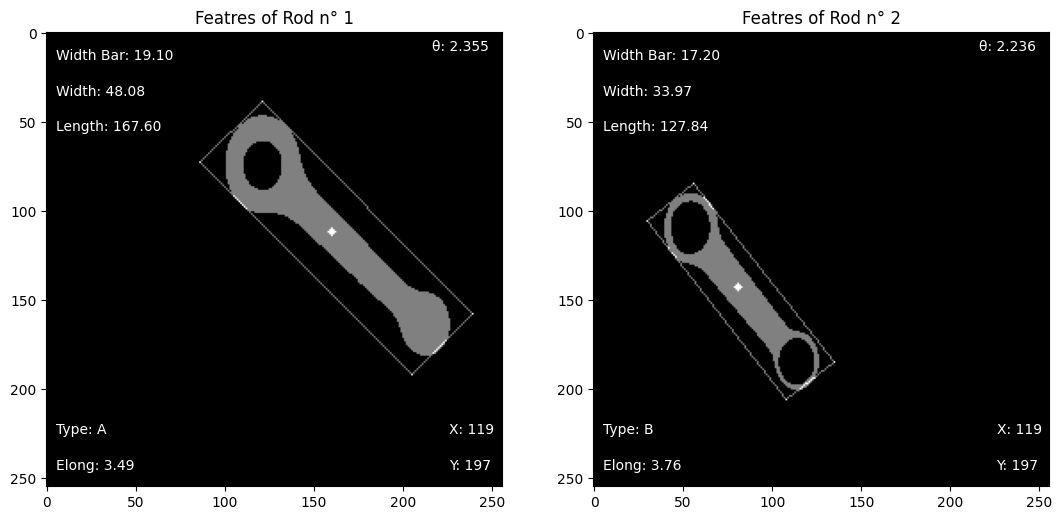

In [405]:
# Save the type and the holes present in the rod
rod_type = []
holes = []


plt.figure(figsize=(20,10))

for idx, obj in enumerate(rods):
    
    # Retrieving the parameters needed to print the final result
    (l1, l2, l3, l4), length, width, bar_width, other_params = rods_info[idx]
    theta, (i_b, j_b) = other_params[:2]
    
    # Find the holes and save them
    holes.append(_2_scan_algorithm(255-obj))
    n_holes = len(np.unique(holes[-1]))-1       # -1 is needed to eliminate the background from the count
    
    # Define the Type of the rod: "Type A" or "Type B"
    if n_holes == 1:
        rod_type.append('A') 
    elif n_holes == 2:
        rod_type.append('B')
    else:
        rod_type.append('Error!')
        
    bar_dot = cv2.circle(np.zeros(obj.shape), (j_b, i_b), 2, (255, 255, 255), -1)
    
    plt.subplot(1, max(len(rods), 3), idx+1)
    plt.imshow(obj+l1+l2+l3+l4+bar_dot, cmap='gray')
    plt.title(f"Featres of Rod n° {idx+1}")
    plt.text(5,15, f"Width Bar: {bar_width:.2f}", c="white", backgroundcolor="black")
    plt.text(5,35, f"Width: {width:.2f}", c="white", backgroundcolor="black")
    plt.text(5,55, f"Length: {length:.2f}", c="white", backgroundcolor="black")
    plt.text(5,obj.shape[0]-30, f"Type: {rod_type[-1]}", c="white", backgroundcolor="black")
    plt.text(5,obj.shape[0]-10, f"Elong: {length/width:.2f}", c="white", backgroundcolor="black")
    plt.text(obj.shape[1]-30,obj.shape[0]-30, f"X: {B[1]}", c="white", backgroundcolor="black")
    plt.text(obj.shape[1]-30,obj.shape[0]-10, f"Y: {B[0]}", c="white", backgroundcolor="black")
    plt.text(obj.shape[1]-40,10, f"θ: {(math.pi/2+theta)%math.pi:.3f}", c="white", backgroundcolor="black")
    
plt.show()

Holes of rod 1


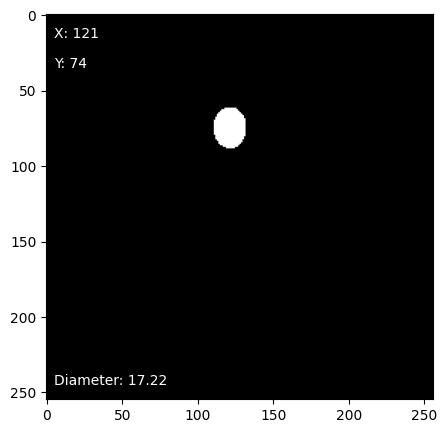

Holes of rod 2


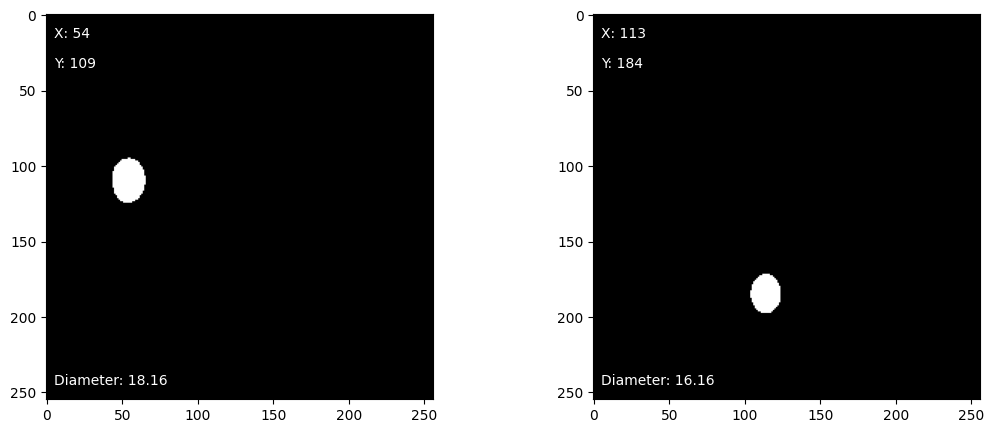

In [406]:
# For each object we will store the information about its holes
holes_obj = []

# Cycling across the holes of each object
for idx, hole in enumerate(holes):
    labels = np.unique(hole)
        
    # Save the features of the holes of each object
    hole_params = []
    
    print(f"Holes of rod {idx+1}")
    
    plt.figure(figsize=(20,5))
    
    h_idx = 0
    
    # Working separately on each hole
    for label in labels:
        h = ((hole == label) * 255).astype('uint8')
        
        # Only for labels that don't represent the background
        if np.sum(h == 255) < h.size//5: 
            
            h_idx += 1
            
            moments_h = get_moments(h)
            # Evaluation of Area, Diameter and Barycenter
            A = moments_h["m00"]
            d = 2*np.sqrt(A/(2*math.pi))
            B = get_barycenter(h)
            
            # Storing the parameters
            hole_params.append((B, d))
            
            plt.subplot(1, len(labels), h_idx+1)
            plt.imshow(h, cmap='gray', vmin=0, vmax=255)
            plt.text(5,15, f"X: {B[1]}",c="white", backgroundcolor="black")
            plt.text(5,35, f"Y: {B[0]}", c="white", backgroundcolor="black")
            plt.text(5,obj.shape[0]-10, "Diameter: "+ str(round(d, 2)), c="white", backgroundcolor="black")
    plt.show()
        
    holes_obj.append(hole_params)

In [407]:
print("Final Report:\n")

for idx in range(len(rods)):
    print("="*50)
    print("\033[1m" + f"Rod {idx+1} - Type {rod_type[idx]}\n" + "\033[0m")
    print(f"Position -> X : {rods_info[idx][4][1][1]}, Y: {rods_info[idx][4][1][0]}")
    print(f"Angle    -> θ : {math.pi/2+rods_info[idx][4][0]:.3f}")
    print(f"Length   -> L : {rods_info[idx][1]:.2f}")
    print(f"Width    -> W : {rods_info[idx][2]:.2f}")
    print(f"Width B. -> Wb: {rods_info[idx][3]:.2f}")
    for h, hole in enumerate(holes_obj[idx]):
        print(f"Hole {h+1}:")
        print(f"\tPosition -> X: {hole[0][1]}, Y: {hole[0][0]}")
        print(f"\tDiameter -> d: {hole[1]:.2f}")
    
print("="*50)

Final Report:

Rod 1 - Type A

Position -> X : 160, Y: 112
Angle    -> θ : 2.355
Length   -> L : 167.60
Width    -> W : 48.08
Width B. -> Wb: 19.10
Hole 1:
	Position -> X: 121, Y: 74
	Diameter -> d: 17.22
Rod 2 - Type B

Position -> X : 81, Y: 143
Angle    -> θ : 2.236
Length   -> L : 127.84
Width    -> W : 33.97
Width B. -> Wb: 17.20
Hole 1:
	Position -> X: 54, Y: 109
	Diameter -> d: 18.16
Hole 2:
	Position -> X: 113, Y: 184
	Diameter -> d: 16.16
